# 🧠 Memoraid: EarlyMed Alzheimer's Disease Detection Using Deep Learning

This notebook implements a Convolutional Neural Network (CNN) for detecting Alzheimer's Disease stages using MRI images. The process includes data loading, preprocessing, model building, training, and evaluation.

---

## 📁 Data Handling

- **Data Source**: Loaded from Google Drive (`Alzheimer_s Dataset` directory).
- **Image Preprocessing**:
  - Applied transformations using `ImageDataGenerator`.
  - Managed image directories using `copy_tree` and `remove_tree` to restructure data for training, validation, and testing.
- **Imbalanced Data**: Code suggests consideration of class imbalance using `imblearn`, though oversampling wasn't explicitly applied.

---

## 🧱 Model Architecture

A deep **Sequential CNN** model was built using Keras. It includes multiple convolutional blocks with separable convolutions and regularization layers.

### 🔍 Layers Breakdown:

1. **Initial Convolutions**:
   - Conv2D (16 filters) → MaxPooling2D
   - Conv2D (32 filters) → MaxPooling2D

2. **Conv Block 1**:
   - SeparableConv2D (64 filters) ×2
   - BatchNormalization → MaxPooling2D

3. **Conv Block 2**:
   - SeparableConv2D (128 filters) ×2
   - BatchNormalization → MaxPooling2D → Dropout(0.2)

4. **Conv Block 3**:
   - SeparableConv2D (256 filters) ×2
   - BatchNormalization → MaxPooling2D → Dropout(0.2)

5. **Dense Layers**:
   - Flatten → Dense(512) → BatchNorm → Dropout(0.4)
   - Dense(128) → BatchNorm → Dropout(0.5)
   - Dense(64) → BatchNorm → Dropout(0.3)
   - Final Layer: Dense(4, activation='softmax') for 4-class classification

---

## ⚙️ Model Compilation

- **Optimizer**: Adam
- **Loss Function**: Categorical Crossentropy
- **Metrics**:
  - Categorical Accuracy
  - AUC (Area Under Curve)




In [ ]:
import pandas as pd
import numpy as np
import os
from distutils.dir_util import copy_tree, remove_tree
import cv2
import matplotlib.pyplot as plt
import warnings

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing import image, image_dataset_from_directory
from imblearn.over_sampling import SMOTE
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow import keras
from random import randint

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
work_dir = '/content/drive/MyDrive/MLProject/Alzheimer_s Dataset'

In [ ]:
import os
from distutils.dir_util import copy_tree, remove_tree
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define paths (adjust if your dataset is in a different location)
default_dir = '/content/drive/MyDrive/MLProject/Alzheimer_s Dataset'  # Update with dataset location
root_dir = '/content/'
train_dir = os.path.join(default_dir, 'train')
work_dir = os.path.join(root_dir, 'dataset')

In [ ]:
default_dir = '/content/drive/MyDrive/MLProject/Alzheimer_s Dataset/'
root_dir = "./"
#test_dir = default_dir + "test/"
train_dir = default_dir + "train/"
work_dir = root_dir + "dataset/"

if os.path.exists(work_dir):
    remove_tree(work_dir)


os.mkdir(work_dir)
copy_tree(train_dir, work_dir)
#copy_tree(test_dir, work_dir)
print("Working Directory Contents:", os.listdir(work_dir))

Working Directory Contents: ['ModerateDemented', 'VeryMildDemented', 'MildDemented', 'NonDemented']


In [ ]:
import os
from distutils.dir_util import copy_tree, remove_tree
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define paths
# Assuming your dataset is in your Google Drive under 'MLProject/Alzheimers_ Dataset/train'
default_dir = '/content/drive/MyDrive/MLProject/Alzheimer_s Dataset'
root_dir = '/content/'
train_dir = os.path.join(default_dir, 'train')  # Construct absolute path to train directory
work_dir = os.path.join(root_dir, 'dataset')

if os.path.exists(work_dir):
    remove_tree(work_dir)

os.mkdir(work_dir)

# Check if train_dir exists and is a directory before copying
if os.path.isdir(train_dir):
    copy_tree(train_dir, work_dir)
    print("Working Directory Contents:", os.listdir(work_dir))
else:
    print(f"Error: '{train_dir}' is not a directory or does not exist.")

Working Directory Contents: ['ModerateDemented', 'VeryMildDemented', 'MildDemented', 'NonDemented']


In [ ]:
# Create working directory
if os.path.exists(work_dir):
    remove_tree(work_dir)
os.mkdir(work_dir)
copy_tree(train_dir, work_dir)
print("Working Directory Contents:", os.listdir(work_dir))

Working Directory Contents: ['ModerateDemented', 'VeryMildDemented', 'MildDemented', 'NonDemented']


In [ ]:
CLASSES = [ 'NonDemented',
            'VeryMildDemented',
            'MildDemented',
            'ModerateDemented']

IMG_SIZE = 176

IMAGE_SIZE = [176, 176]
DIM = (IMG_SIZE, IMG_SIZE)

In [ ]:
ZOOM = [.99, 1.01]
BRIGHT_RANGE = [0.8, 1.2]
HORZ_FLIP = True
FILL_MODE = "constant"
DATA_FORMAT = "channels_last"

image_generator = ImageDataGenerator(rescale = 1./255, brightness_range=BRIGHT_RANGE, zoom_range=ZOOM,
                                     data_format=DATA_FORMAT, fill_mode=FILL_MODE, horizontal_flip=HORZ_FLIP)

In [ ]:
train_dataset = image_generator.flow_from_directory(batch_size=5200,
                                                    directory=work_dir,
                                                    target_size=(176, 176),
                                                    shuffle= True)


Found 6400 images belonging to 4 classes.


## Visualization

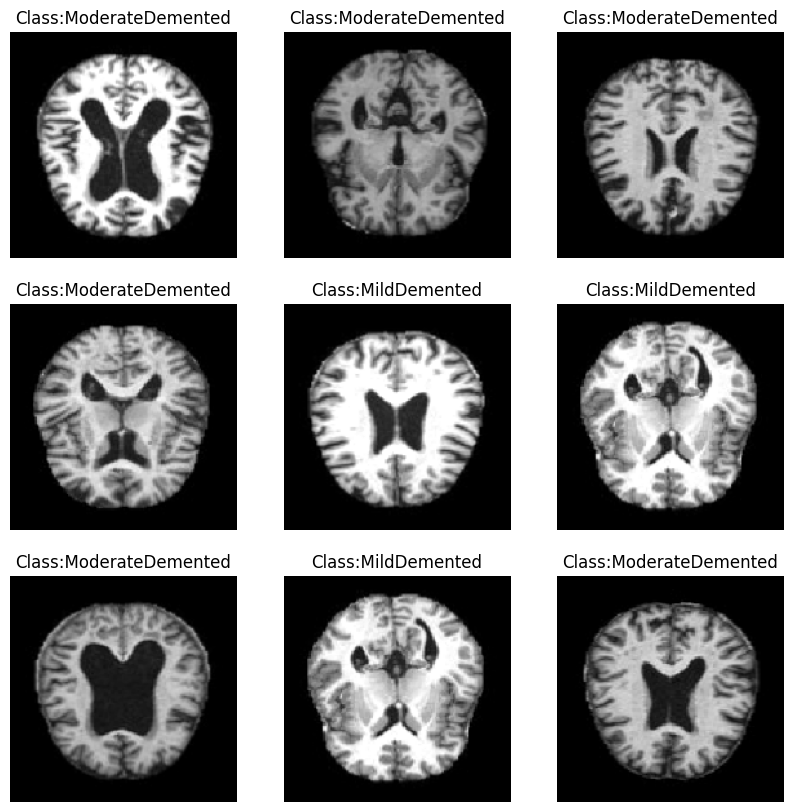

In [ ]:
def show_images(generator,y_pred=None):

    labels =dict(zip([0,1,2,3], CLASSES))

    # get a lot of images
    x,y = next(generator) # Changed line

    # show a grid of 9 images
    plt.figure(figsize=(10, 10))
    if y_pred is None:
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            idx = randint(0,50)
            plt.imshow(x[idx])
            plt.axis("off")
            plt.title("Class:{}".format(labels[np.argmax(y[idx])]))

    else:
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(x[i])
            plt.axis("off")
            plt.title("Actual:{} \nPredicted:{}".format(labels[np.argmax(y[i])],labels[y_pred[i]]))

# Display Train Images
show_images(train_dataset)

<BarContainer object of 4 artists>

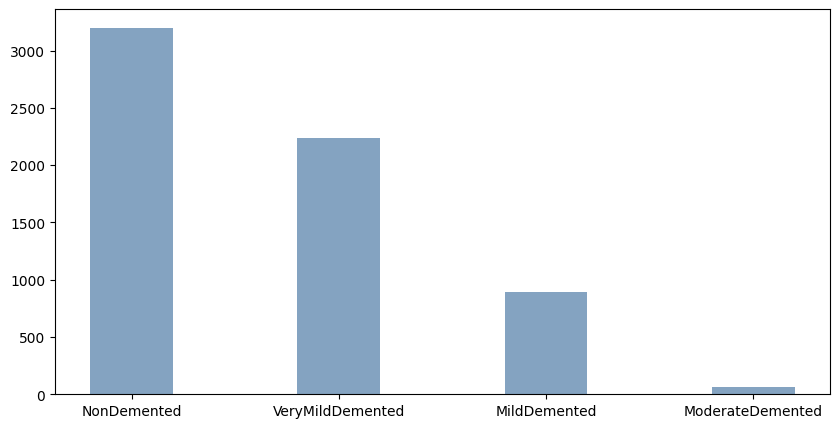

In [ ]:
data = {'NonDemented':      0,
        'VeryMildDemented': 0,
        'MildDemented':     0,
        'ModerateDemented': 0}

# visualizing dataset
for cls in os.listdir(work_dir):
    for img in os.listdir(work_dir + '/' + cls):
        data[cls] = data[cls] + 1

keys = list(data.keys())
values = list(data.values())

fig = plt.figure(figsize = (10, 5))

plt.bar(keys, values, color=(0.2, 0.4, 0.6, 0.6), width = 0.4)

## Feature Engineering and Oversampling

In [ ]:
train_data, train_labels = next(train_dataset) # Use next(train_dataset) to get the next batch

In [ ]:
print(train_data.shape, train_labels.shape)

(1200, 176, 176, 3) (1200, 4)


In [ ]:
#resampling data

sm = SMOTE(random_state=42)

train_data, train_labels = sm.fit_resample(train_data.reshape(-1, IMG_SIZE * IMG_SIZE * 3), train_labels)

train_data = train_data.reshape(-1, IMG_SIZE, IMG_SIZE, 3)

print(train_data.shape, train_labels.shape)

(2308, 176, 176, 3) (2308, 4)


In [ ]:
from sklearn.model_selection import train_test_split
train_data, test_data, train_labels, test_labels = train_test_split(train_data, train_labels, test_size = 0.2, random_state=42)
train_data, val_data, train_labels, val_labels = train_test_split(train_data, train_labels, test_size = 0.2, random_state=42)

# Training models

## CNN

In [ ]:
model = keras.models.Sequential([
keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape = [176,176,3]),
keras.layers.MaxPooling2D(),
keras.layers.Conv2D(32, (2, 2), activation='relu'),
keras.layers.MaxPooling2D(),

keras.layers.SeparableConv2D(64, 3, activation='relu', padding='same'),
keras.layers.SeparableConv2D(64, 3, activation='relu', padding='same'),
keras.layers.BatchNormalization(),
keras.layers.MaxPool2D(),

keras.layers.SeparableConv2D(128, 3, activation='relu', padding='same'),
keras.layers.SeparableConv2D(128, 3, activation='relu', padding='same'),
keras.layers.BatchNormalization(),
keras.layers.MaxPool2D(),
keras.layers.Dropout(0.2),

keras.layers.SeparableConv2D(256, 3, activation='relu', padding='same'),
keras.layers.SeparableConv2D(256, 3, activation='relu', padding='same'),
keras.layers.BatchNormalization(),
keras.layers.MaxPool2D(),
keras.layers.Dropout(0.2),

keras.layers.Flatten(),

keras.layers.Dense(512, activation='relu'),
keras.layers.BatchNormalization(),
keras.layers.Dropout(0.4),

keras.layers.Dense(128, activation='relu'),
keras.layers.BatchNormalization(),
keras.layers.Dropout(0.5),

keras.layers.Dense(64, activation='relu'),
keras.layers.BatchNormalization(),
keras.layers.Dropout(0.3),

keras.layers.Dense(4, activation ='softmax')])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
model.compile(
        optimizer='adam',
        loss=tf.losses.CategoricalCrossentropy(),
        metrics=[tf.keras.metrics.CategoricalAccuracy(name='acc'),
                 keras.metrics.AUC(name='auc')]
    )

In [ ]:
# Assuming your labels are currently integers (0, 1, 2, 3)
import tensorflow as tf

num_classes = 4  # Number of classes in your dataset

# One-hot encode the labels
train_labels = tf.keras.utils.to_categorical(train_labels, num_classes=num_classes)
val_labels = tf.keras.utils.to_categorical(val_labels, num_classes=num_classes)
test_labels = tf.keras.utils.to_categorical(test_labels, num_classes=num_classes)

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, Dropout, Conv2D, MaxPooling2D, SeparableConv2D, BatchNormalization

In [ ]:
def create_model():  # Define a function to create the model
    model = keras.models.Sequential([
        Conv2D(16, (3, 3), activation='relu', input_shape=[176, 176, 3]),
        MaxPooling2D(), # Changed from MaxPool2D to MaxPooling2D
        Conv2D(32, (2, 2), activation='relu'),
        MaxPooling2D(), # Changed from MaxPool2D to MaxPooling2D

        SeparableConv2D(64, 3, activation='relu', padding='same'),
        SeparableConv2D(64, 3, activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D(), # Changed from MaxPool2D to MaxPooling2D

        SeparableConv2D(128, 3, activation='relu', padding='same'),
        SeparableConv2D(128, 3, activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D(), # Changed from MaxPool2D to MaxPooling2D
        Dropout(0.2),

        SeparableConv2D(256, 3, activation='relu', padding='same'),
        SeparableConv2D(256, 3, activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D(), # Changed from MaxPool2D to MaxPooling2D
        Dropout(0.2),

        Flatten(),

        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(0.4),

        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),

        Dense(64, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),

        Dense(4, activation='softmax')
    ])
    return model

In [ ]:
# ipython-input-20-82444ffe982b
# Assuming your labels are currently integers (0, 1, 2, 3)
import tensorflow as tf

num_classes = 4  # Number of classes in your dataset

# Check if labels are already one-hot encoded
if train_labels.ndim == 1:  # If labels are 1D (integers)
    # One-hot encode the labels
    train_labels = tf.keras.utils.to_categorical(train_labels, num_classes=num_classes)
    val_labels = tf.keras.utils.to_categorical(val_labels, num_classes=num_classes)
    test_labels = tf.keras.utils.to_categorical(test_labels, num_classes=num_classes)
else:  # If labels are already one-hot encoded
    print("Labels are already one-hot encoded. Skipping to_categorical.")

Labels are already one-hot encoded. Skipping to_categorical.


In [ ]:
# ipython-input-20-82444ffe982b
# Assuming your labels are currently integers (0, 1, 2, 3)
import tensorflow as tf

num_classes = 4  # Number of classes in your dataset

# Check if labels are already one-hot encoded
if train_labels.ndim == 1:  # If labels are 1D (integers)
    # One-hot encode the labels
    train_labels = tf.keras.utils.to_categorical(train_labels, num_classes=num_classes)
    val_labels = tf.keras.utils.to_categorical(val_labels, num_classes=num_classes)
    test_labels = tf.keras.utils.to_categorical(test_labels, num_classes=num_classes)
else:  # If labels are already one-hot encoded
    print("Labels are already one-hot encoded. Skipping to_categorical.")

Labels are already one-hot encoded. Skipping to_categorical.


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, Dropout, Conv2D, MaxPooling2D, SeparableConv2D, BatchNormalization


def create_model():
    model = keras.models.Sequential([
        Conv2D(16, (3, 3), activation='relu', input_shape=[176, 176, 3]),
        MaxPooling2D(),
        Conv2D(32, (2, 2), activation='relu'),
        MaxPooling2D(),

        SeparableConv2D(64, 3, activation='relu', padding='same'),
        SeparableConv2D(64, 3, activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D(),

        SeparableConv2D(128, 3, activation='relu', padding='same'),
        SeparableConv2D(128, 3, activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D(),
        Dropout(0.2),

        SeparableConv2D(256, 3, activation='relu', padding='same'),
        SeparableConv2D(256, 3, activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D(),
        Dropout(0.2),

        Flatten(),

        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(0.4),

        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),

        Dense(64, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),

        Dense(4, activation='softmax')
    ])
    return model

# Creating the model
model = create_model()

model.compile(
    optimizer='adam',
    loss=tf.losses.CategoricalCrossentropy(),
    metrics=[tf.keras.metrics.CategoricalAccuracy(name='acc'),
             keras.metrics.AUC(name='auc')]
)

# Check if labels need to be one-hot encoded or are already encoded
# --- The fix is in this section ---
if train_labels.ndim == 1:  # Labels are not one-hot encoded
    train_labels = tf.keras.utils.to_categorical(train_labels, num_classes=4)
    val_labels = tf.keras.utils.to_categorical(val_labels, num_classes=4)
    test_labels = tf.keras.utils.to_categorical(test_labels, num_classes=4)
else:
    # If labels are already one-hot encoded, ensure they have the correct shape
    # If the shape is (batch_size, 4, 4), convert to (batch_size, 4)
    if train_labels.shape[1:] == (4, 4):
        train_labels = train_labels[:, 0, :]  # Select the first row from the second dimension
        val_labels = val_labels[:, 0, :]
        test_labels = test_labels[:, 0, :]
    print("Labels are already one-hot encoded or have been reshaped. Skipping to_categorical.")
# --- End of fix ---

history = model.fit(train_data, train_labels, validation_data=(val_data, val_labels), epochs=50)

Labels are already one-hot encoded or have been reshaped. Skipping to_categorical.
Epoch 1/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 65s 1s/step - acc: 0.2903 - auc: 0.5264 - loss: 1.9807 - val_acc: 0.7270 - val_auc: 0.8180 - val_loss: 1.0722
Epoch 2/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 81s 1s/step - acc: 0.4077 - auc: 0.6565 - loss: 1.4746 - val_acc: 0.7270 - val_auc: 0.9090 - val_loss: 0.9108
Epoch 3/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 65s 1s/step - acc: 0.5261 - auc: 0.7574 - loss: 1.1830 - val_acc: 0.7270 - val_auc: 0.9090 - val_loss: 0.8630
Epoch 4/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 70s 1s/step - acc: 0.6262 - auc: 0.8352 - loss: 0.9801 - val_acc: 0.7270 - val_auc: 0.9090 - val_loss: 0.8038
Epoch 5/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 61s 1s/step - acc: 0.6442 - auc: 0.8542 - loss: 0.9177 - val_acc: 0.7270 - val_auc: 0.9090 - val_loss: 0.7613
Epoch 6/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 54s 1s/step - acc: 0.7006 - auc: 0.8937 - loss: 0.7807 - val_acc: 0.7270 - val_auc: 0.9090 - val_loss: 0.7614
Epoch 7/50
47/47 ━━━━━━━━━━━━

Execution time: 1 hour 52 mins 29 seconds \
Last execution time: 1 hour 4 mins 10 seconds, 11/02/2025

In [ ]:
loss, accuracy,auc = model.evaluate(test_data, test_labels)
print("Loss: ", loss)
print("Accuracy: ", accuracy)

15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 323ms/step - acc: 0.9389 - auc: 0.9883 - loss: 0.1974
Loss:  0.16579778492450714
Accuracy:  0.9502164721488953


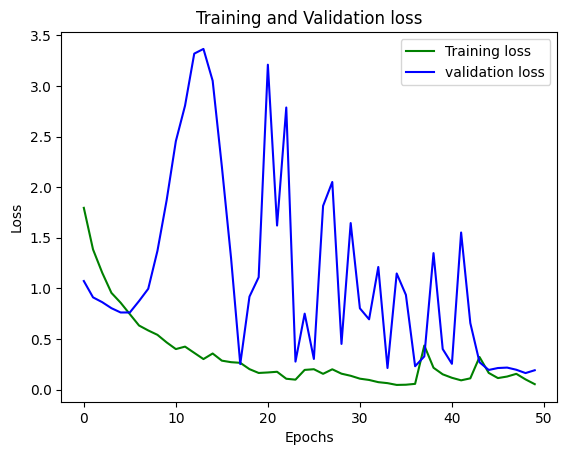

In [ ]:
loss_train = history.history['loss']
loss_val = history.history['val_loss']
epochs = range(0,50)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

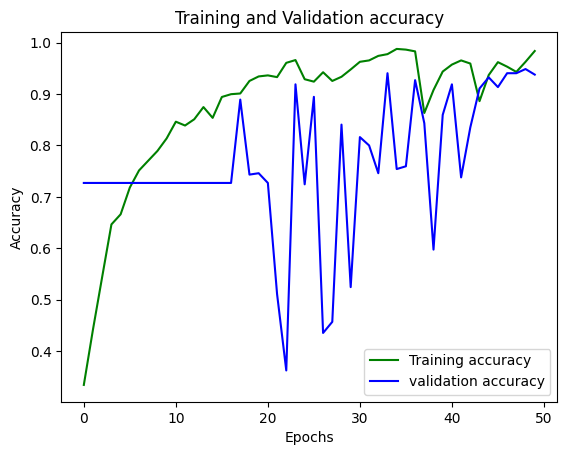

In [ ]:
acc_train = history.history['acc']
acc_val = history.history['val_acc']
epochs = range(0,50)
plt.plot(epochs, acc_train, 'g', label='Training accuracy')
plt.plot(epochs, acc_val, 'b', label='validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [ ]:
model.save('alzheimer_cnn_model.h5')

In [ ]:
from google.colab import files
files.download("alzheimer_cnn_model.h5")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from pathlib import Path
from PIL import Image
from tensorflow.keras.preprocessing.image import load_img, img_to_array
#Image path
path = Path('/content/non_2.jpg')
img = image.load_img(path, target_size=(176,176))
image_array = img_to_array(img) / 255.0  # Ensure same normalization as training
image_array = np.expand_dims(image_array, axis=0)

img_array = image_array.reshape((1, 176, 176, 3))


predictions = model.predict(image_array)

#print(predictions)
predicted_label = CLASSES[np.argmax(predictions)]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 490ms/step


In [ ]:
from pathlib import Path
from PIL import Image
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np
from tensorflow import keras


# --- Your CLASSES definition ---
CLASSES = ['NonDemented', 'VeryMildDemented', 'MildDemented', 'ModerateDemented']

# --- Model loading ---
model = keras.models.load_model('alzheimer_cnn_model.h5')

# Image path
path = Path('/content/non_3.jpg')
img = image.load_img(path, target_size=(176, 176))
image_array = img_to_array(img) / 255.0  # Ensure same normalization as training
image_array = np.expand_dims(image_array, axis=0)

predictions = model.predict(image_array)

predicted_class_index = np.argmax(predictions)
predicted_label = CLASSES[predicted_class_index]

print("Predicted Label:", predicted_label)

In [ ]:
from pathlib import Path
from PIL import Image
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np
from tensorflow import keras

# --- Your CLASSES definition ---
CLASSES = ['NonDemented', 'VeryMildDemented', 'MildDemented', 'ModerateDemented']

# --- Model loading ---
model = keras.models.load_model('mod', compile=False)  # Load without compiling
model.compile(loss='categorical_crossentropy', metrics=['accuracy']) # Re-compile the model

# Image path
path = Path('/content/non_19.jpg')
img = image.load_img(path, target_size=(176, 176))
image_array = img_to_array(img) / 255.0  # Ensure same normalization as training
image_array = np.expand_dims(image_array, axis=0)  # Add batch dimension


predictions = model.predict(image_array)

predicted_class_index = np.argmax(predictions)
predicted_label = CLASSES[predicted_class_index]

print("Predicted Label:", predicted_label)

In [ ]:
from pathlib import Path
from PIL import Image
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np
from tensorflow import keras

# --- Your CLASSES definition ---
CLASSES = ['NonDemented', 'VeryMildDemented', 'MildDemented', 'ModerateDemented']

# --- Model loading ---
model = keras.models.load_model('my_model.h5', compile=False)
model.compile(loss='categorical_crossentropy', metrics=['accuracy'])

# --- Preprocessing function ---
def preprocess_image(image_path):
    img = image.load_img(image_path, target_size=(176, 176))
    image_array = img_to_array(img) / 255.0  # Ensure same normalization as training
    image_array = np.expand_dims(image_array, axis=0)
    return image_array

# Image path
path = Path('/content/moderate_15.jpg')

# Preprocess the image
preprocessed_image = preprocess_image(path)

# Make predictions
predictions = model.predict(preprocessed_image)

predicted_class_index = np.argmax(predictions)
predicted_label = CLASSES[predicted_class_index]

print("Predicted Label:", predicted_label)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step
Predicted Label: NonDemented
